In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import math
import statsmodels.api as sm

In [2]:
# Parameters
save_figures = False
save_files = False

# Load the data and convert to numerical data

## Load data

In [3]:
data = pd.read_csv('../data/papers_reviewed_reprod_variables.csv', index_col=0)
data.head(5)

,DOI,DOI_short,Methodology,Publisher,Year,data_listed,data_metadata,data_stats,data_type,data_access,...,eval_metrics,eval_sig_test,code_link,code_empty,code_preproc,code_features_gen,code_eval,code_params_opt,code_info,code_runable
Paper ID,,,,,,,,,,,,,,,,,,,,,
1,https://doi.org/10.1109/CCDC.2014.6852414,10.1109/CCDC.2014.6852414,MB+ML,IEEE,2014,n,y,n,real-world,No Information,...,"Charts, Error Est.",n,n,na,na,na,na,na,na,na
2,https://doi.org/10.1109/ICTAI.2018.00136,10.1109/ICTAI.2018.00136,ML,IEEE,2018,n,y,n,real-world,proprietary,...,"Precision, Recall",y,n,na,na,na,na,na,na,na
3,https://doi.org/10.1109/ICVR57957.2023.10169760,10.1109/ICVR57957.2023.10169760,MB+ML+KB,IEEE,2023,n,n,n,No Information,No Information,...,"""Operational KPIs (man hour reduction, timelin...",n,n,na,na,na,na,na,na,na
4,https://doi.org/10.1109/AIKIIE60097.2023.10390401,10.1109/AIKIIE60097.2023.10390401,MB+ML,IEEE,2023,n,n,n,simulation,No Information,...,"Accuracy, F1 score, FPR, TPR",n,n,na,na,na,na,na,na,na
5,https://doi.org/10.1109/ICICT55905.2022.00043,10.1109/ICICT55905.2022.00043,MB+ML+KB,IEEE,2022,n,y,n,"real-world, simulation",No Information,...,"Accuracy, Loss",n,n,na,na,na,na,na,na,na


Functions for figure generation

In [4]:
def gen_boxplot(data, tick_labels, title, ylabel, show_stats=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    box = ax.boxplot(
        data, 
        tick_labels=tick_labels, 
        showmeans=True, 
        meanline=True)

    if show_stats:
        # Add annotations for mean, median, and quartiles
        for i, dataset in enumerate(data):
            mean = np.mean(dataset)
            median = np.median(dataset)
            q1 = np.percentile(dataset, 25)
            q3 = np.percentile(dataset, 75)
            
            text = f"Q3: {q3:.2f}\nMean: {mean:.2f}\nMedian: {median:.2f}\nQ1: {q1:.2f}"

            if len(data) == 2:
                offset_x = 1.1
            else:
                offset_x = 1.2
                
            ax.text(i + offset_x, (q1+q3)/2, text, ha='left', va='center', fontsize=10)

    ax.set_title(title)
    ax.set_ylabel(ylabel)

    if ax is None:
        fig.tight_layout()
        return fig, ax
    else:
        return ax
            

In [5]:
def gen_heatmap(numeric_data, title='Reproducibility Variables', xlabel='Reproducibility Variables', save=None):
    plt.figure(figsize=(10, 10))
    sns.heatmap(numeric_data, annot=False, vmin=0, vmax=1, center=0.5, cmap='vlag_r', yticklabels=numeric_data.index)
    plt.yticks(rotation=0)
    plt.xlabel(title)
    plt.title(xlabel)
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

In [6]:
def gen_histogram(subject_df, subject_name, stat_type='subject'):
    if stat_type == 'subject':
        title_string = f'Cited-by-count of authors with {subject_name} in subject area'
    elif stat_type == 'affil':
        title_string = f'Cited-by-count of authors with {subject_name} affiliation'

    # Create subfigures for linear and log scale
    fig, axs = plt.subplots(3, 1, figsize=(12, 6))

    # Calculate the maximum value for scaling
    value_max = max(subject_df.values())
    rounded_max = int(math.ceil(value_max / 1000.0) * 1000)

    axs[0].hist([int(citation) for citation in subject_df.values()], bins=30, color='blue', alpha=0.7)
    axs[0].set_title(f'{title_string}')
    axs[0].set_xlabel('cited-by-count')
    axs[0].set_xlim(0, rounded_max)
    axs[0].set_ylabel('Frequency')

    # up to 1/10 of the maximum value
    limit = int(rounded_max / 10)
    axs[1].hist([int(citation) for citation in subject_df.values() if int(citation) <= limit], bins=30, color='blue', alpha=0.7)
    axs[1].set_title(f'{title_string} (up to {limit} Citations)')
    axs[1].set_xlabel('cited-by-count')
    axs[1].set_xlim(0, limit)
    axs[1].set_ylabel('Frequency')

    # up to 1/100 of the maximum value
    limit = int(rounded_max / 100)
    axs[2].hist([int(citation) for citation in subject_df.values() if int(citation) <= limit], bins=30, color='blue', alpha=0.7)
    axs[2].set_title(f'{title_string} (up to {limit} Citations)')
    axs[2].set_xlabel('cited-by-count')
    axs[2].set_xlim(0, limit)
    axs[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


## Convert categorial data to numeric data

For each possible entry a mapping to numerical values is conducted.

In [7]:
numeric_mapping = {
    "y": 1,
    "n": 0,
    "na": 0,
    "not mentioned": 0,
    "real-world": 1,
    "simulation": 1,
    "experiment": 1,
    "real-world, simulation": 1,
    "proprietary": 1,
    "public": 1, 
    "purchasable": 1,
    "Single-Split": 1,
    "T/V/T": 1,
    "Cross Validation": 1,
    "Out of Sample": 1,
    "No Information": 0,
}

In [8]:
# Convert categorical data to numeric
numeric_data = data.copy()
for col in numeric_data.columns:
    numeric_data[col] = numeric_data[col].map(numeric_mapping).fillna(numeric_data[col])
    if col == "eval_metrics":
        # Special case for eval_metrics to handle multiple values
        numeric_data[col] = numeric_data[col].apply(lambda x: 0 if x == "no metrics" else 1)
    
numeric_data.head(5)

,DOI,DOI_short,Methodology,Publisher,Year,data_listed,data_metadata,data_stats,data_type,data_access,...,eval_metrics,eval_sig_test,code_link,code_empty,code_preproc,code_features_gen,code_eval,code_params_opt,code_info,code_runable
Paper ID,,,,,,,,,,,,,,,,,,,,,
1,https://doi.org/10.1109/CCDC.2014.6852414,10.1109/CCDC.2014.6852414,MB+ML,IEEE,2014.0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,https://doi.org/10.1109/ICTAI.2018.00136,10.1109/ICTAI.2018.00136,ML,IEEE,2018.0,0,1,0,1,1,...,1,1,0,0,0,0,0,0,0,0
3,https://doi.org/10.1109/ICVR57957.2023.10169760,10.1109/ICVR57957.2023.10169760,MB+ML+KB,IEEE,2023.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,https://doi.org/10.1109/AIKIIE60097.2023.10390401,10.1109/AIKIIE60097.2023.10390401,MB+ML,IEEE,2023.0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,https://doi.org/10.1109/ICICT55905.2022.00043,10.1109/ICICT55905.2022.00043,MB+ML+KB,IEEE,2022.0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0


## Calculate Scores
For the different categories of the reproducability variables (see Table 1) the average score is calculated. The same is done for the dimensions and degree (see Figure 3)

In [9]:
# Calculate scores for each sub-category of the variables
def calculate_sub_scores(df):
    scores = pd.DataFrame(index=df.index)
    scores['Data'] = df[['data_listed', 'data_metadata', 'data_stats', 'data_type', 'data_access']].mean(axis=1)
    scores['Preprocessing'] = df[['preproc_data', 'preproc_features', 'multiple data']].mean(axis=1)
    scores['Method'] = df[['opt_mentioned', 'opt_baseline', 'opt_procedure', 'params_model', 'params_baseline', 'params_best_model', 'params_best_baseline']].mean(axis=1)
    scores['Experiment'] = df[['eval_splitting', 'eval_metrics', 'eval_sig_test']].mean(axis=1)
    scores['Code'] = df[['code_link', 'code_empty', 'code_preproc', 'code_features_gen', 'code_eval', 'code_params_opt', 'code_info', 'code_runable']].mean(axis=1)
    scores['Total'] = scores[['Data', 'Preprocessing', 'Method', 'Experiment', 'Code']].mean(axis=1)
    return scores

scores = calculate_sub_scores(numeric_data)

if save_files:
    scores.to_csv('scores.csv', index=True)
    


In [10]:
# Calculate scores for the dimensions and the overall degree
def calcualte_dimensions(df):
    list_D1  = ['data_listed', 'data_stats', 'data_type', 'data_access']
    list_D2 = ['data_stats', 'data_metadata', 'preproc_data', 'preproc_features', 'code_link', 'code_features_gen', 'code_preproc', 'opt_procedure', 'opt_mentioned', 'params_model']
    list_D3 = ['data_stats', 'data_metadata', 'preproc_data', 'preproc_features', 'code_link', 'code_features_gen', 'code_preproc', 'code_eval', 'eval_metrics', 'params_best_model', 'params_best_baseline', 'eval_splitting']
    combined = list_D1 + list_D2 + list_D3
    combined_unique = list(set(combined))

    dimensions = pd.DataFrame(index=df.index)
    dimensions['D1'] = df[list_D1].mean(axis=1)
    dimensions['D2'] = df[list_D2].mean(axis=1)
    dimensions['D3'] = df[list_D3].mean(axis=1)

    dimensions['degree'] = df[combined_unique].mean(axis=1)
    return dimensions

dimensions = calcualte_dimensions(numeric_data)

if save_files:
    dimensions.to_csv('dimensions.csv', index=True)


# Data Visualization

In the following different data visualization are conducted. 

1. Heatmaps of the reproducability variables, classes and dimensions
2. Author Analyis: Subjects
3. Author Analyis: Affiliation
5. Reproducability vs. Subject
4. Reproducability vs. Affilation

## 1. Heatmaps

### Reproducability variables

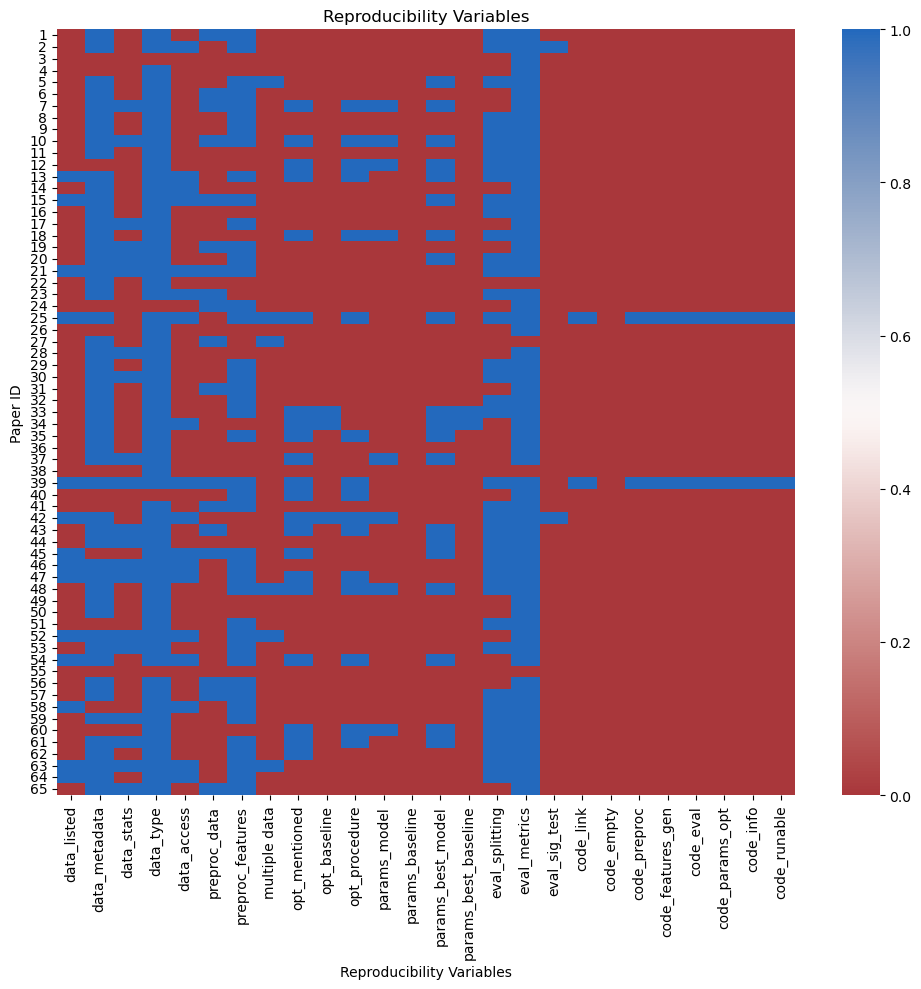

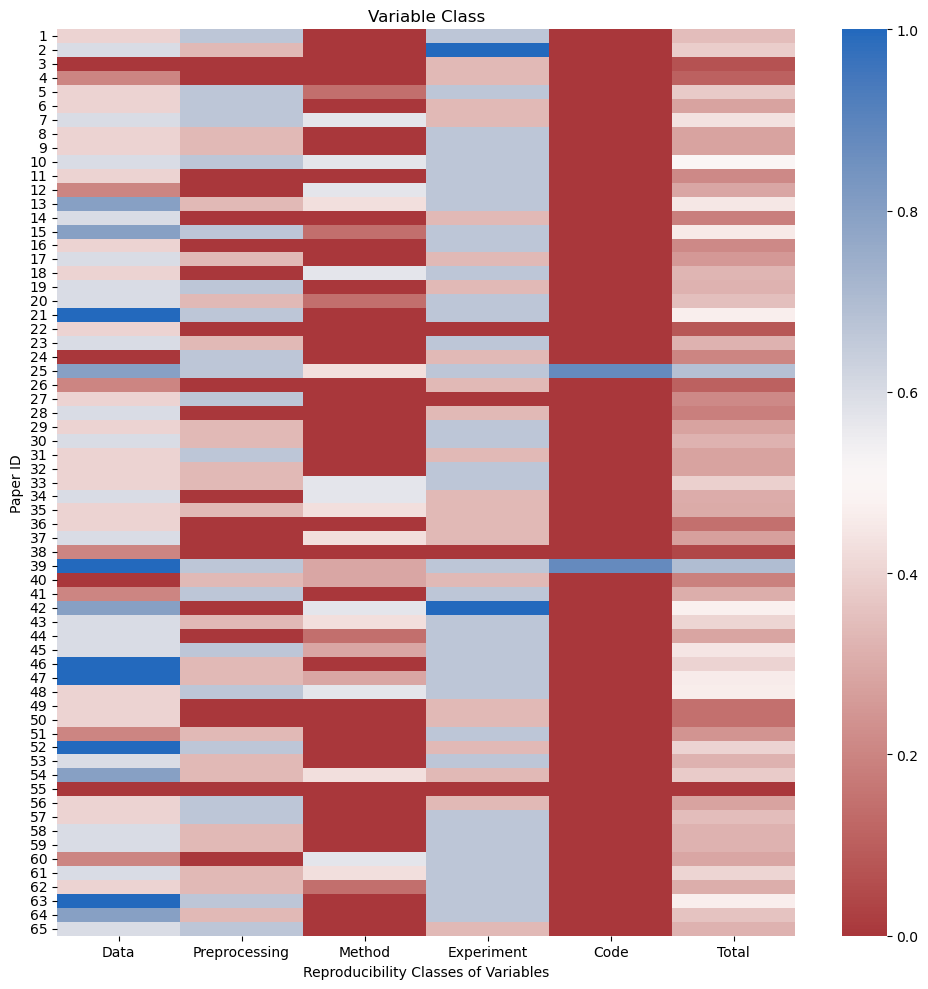

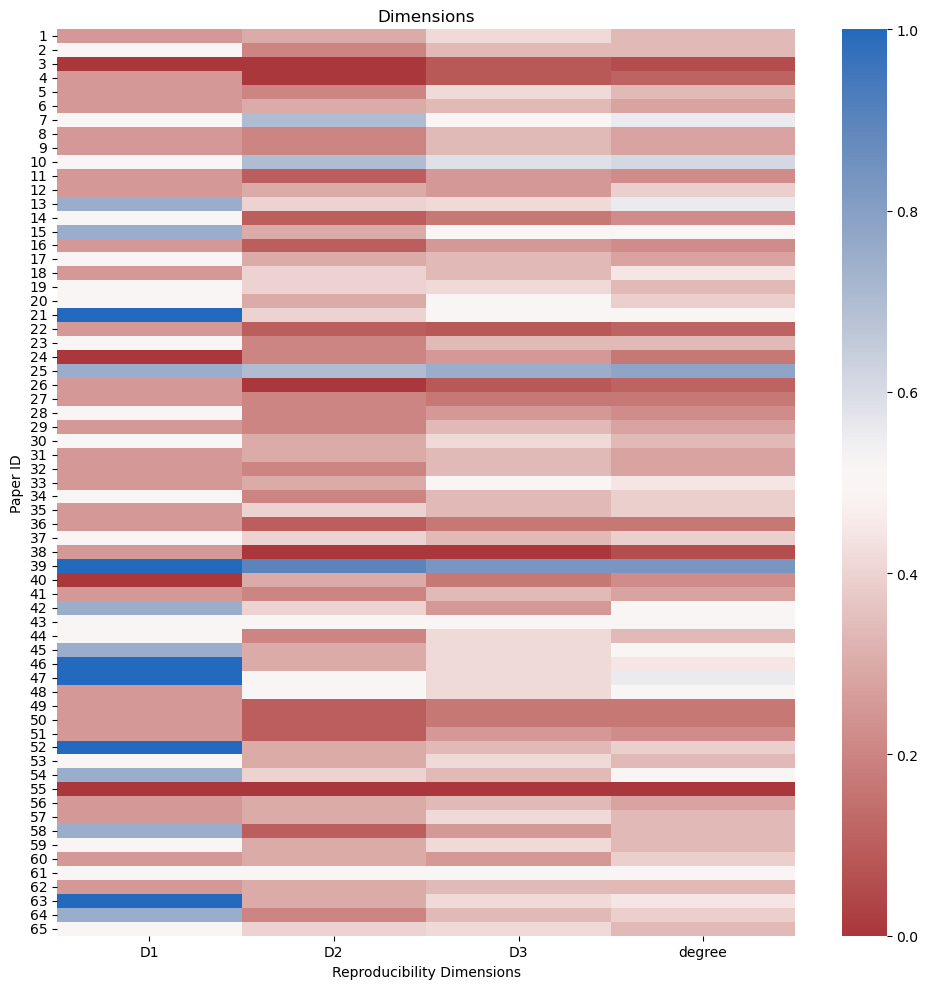

In [11]:
gen_heatmap(numeric_data.drop(columns=["DOI", "DOI_short", "Methodology", "Publisher", "Year"]), title='Reproducibility Variables', xlabel='Reproducibility Variables', save='../results/heatmap_variables.pdf')
gen_heatmap(scores, title='Reproducibility Classes of Variables', xlabel='Variable Class')
gen_heatmap(dimensions, title='Reproducibility Dimensions', xlabel='Dimensions')

## 2. Author Analysis: Subjects

For the analysis to the authors the Scopus API was used (for details see `2_scopus_api_call.ipynb`)

In [12]:
with open('../data/bibliometric_data.json') as f:
    scopus_data = json.load(f)


### Extract Subjects
Create a statistic about the subjects present as well as seperate variables for the two most prominent subjects (Engineering & Computer Science).

In [13]:
subjects = {}
papers_subjects = {}
authors_num = 0
engineering = {}
cs = {}
cs_papers = {}
non_cs_papers = {}
author_list = []
for paper in scopus_data:
    authors = paper.get('authors', [])
    paper_level_subjects = {}
    for author in authors: 
        subject_area = author.get('subject-area')

        for subject in subject_area:
            if subject not in paper_level_subjects:
                paper_level_subjects[subject] = 1

        if author['author-url'] in author_list:
            # print(f'Author {author['author-url']} skipped')
            continue

        authors_num += 1
        author_list.append(author['author-url'])
    
        for subject in subject_area:
            if subject not in subjects:
                subjects[subject] = 0
            subjects[subject] += 1
            if subject == 'Engineering (all)':
                engineering[author['author-url']] = int(author.get('cited-by-count'))
            if subject == 'Computer Science (all)':
                cs[author['author-url']] = int(author.get('cited-by-count'))

    for subject in paper_level_subjects:
        if subject not in papers_subjects:
            papers_subjects[subject] = 0
        papers_subjects[subject] += 1
    if 'Computer Science (all)' in paper_level_subjects:
        cs_papers[paper['doi']] = paper['citation-count']
    else:
        non_cs_papers[paper['doi']] = paper['citation-count']
   
papers_subjects = dict(sorted(papers_subjects.items(), key=lambda item: item[1], reverse=True))
subjects = dict(sorted(subjects.items(), key=lambda item: item[1], reverse=True))

engineering = dict(sorted(engineering.items(), key=lambda item: item[1], reverse=True))
cs = dict(sorted(cs.items(), key=lambda item: item[1], reverse=True))

print('Num of unique authors:', authors_num)
print('Num of subjects:', len(subjects))

subjects

Num of unique authors: 243
Num of subjects: 15


{'Engineering (all)': 175,
 'Computer Science (all)': 145,
 'Energy (all)': 46,
 'Mathematics (all)': 36,
 'Environmental Science (all)': 17,
 'Physics and Astronomy (all)': 12,
 'Decision Sciences (all)': 10,
 'Chemical Engineering (all)': 7,
 'Earth and Planetary Sciences (all)': 6,
 'Medicine (all)': 5,
 'Materials Science (all)': 3,
 'Multidisciplinary': 3,
 'Social Sciences (all)': 2,
 'Biochemistry, Genetics and Molecular Biology (all)': 1,
 'Business, Management and Accounting (all)': 1}

### Subject Analysis
The distribution of the subject assigned to each author by scopus was investigated. 
Only the unique authors where used. 

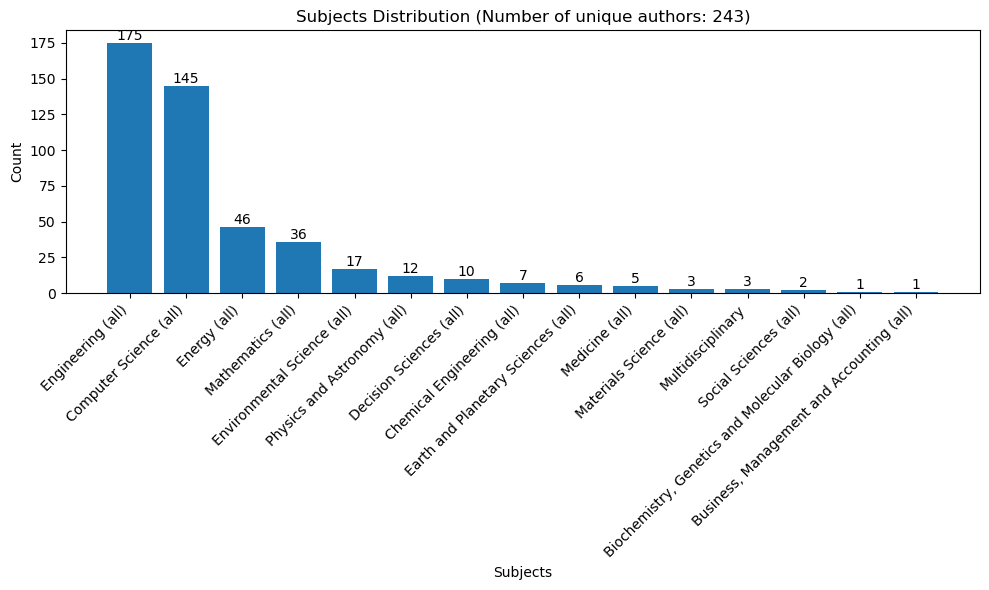

In [14]:
# Create a bar chart for subjects
plt.figure(figsize=(10, 6))
bars = plt.bar(subjects.keys(), subjects.values())
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.title(f'Subjects Distribution (Number of unique authors: {authors_num})')
plt.xlabel('Subjects')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Distribution of subjects that are included in at least of of the authors subject list. 

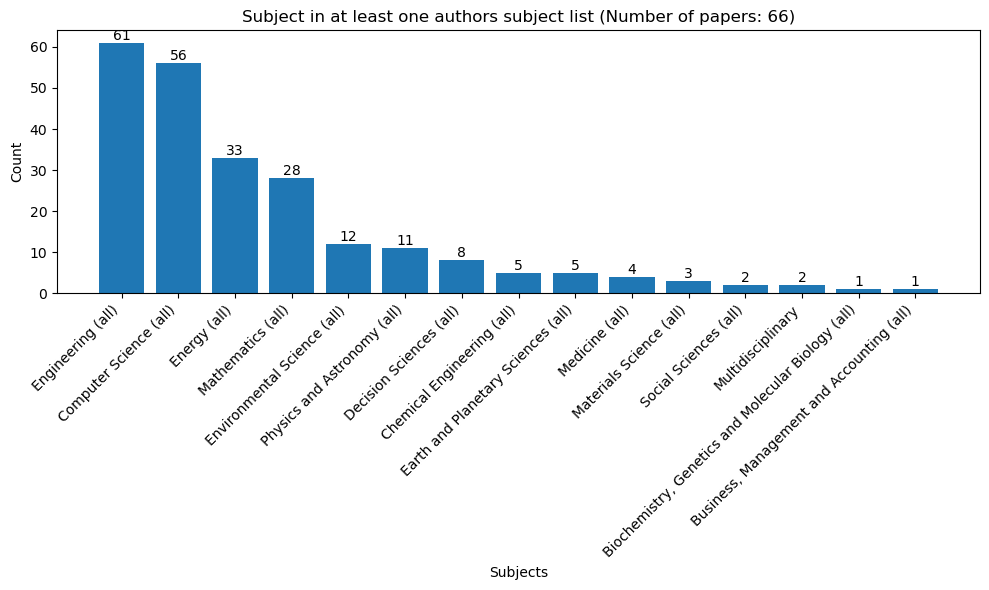

In [15]:
plt.figure(figsize=(10, 6))
bars = plt.bar(papers_subjects.keys(), papers_subjects.values())
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.title(f'Subject in at least one authors subject list (Number of papers: {len(scopus_data)})')
plt.xlabel('Subjects')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Citation Analysis

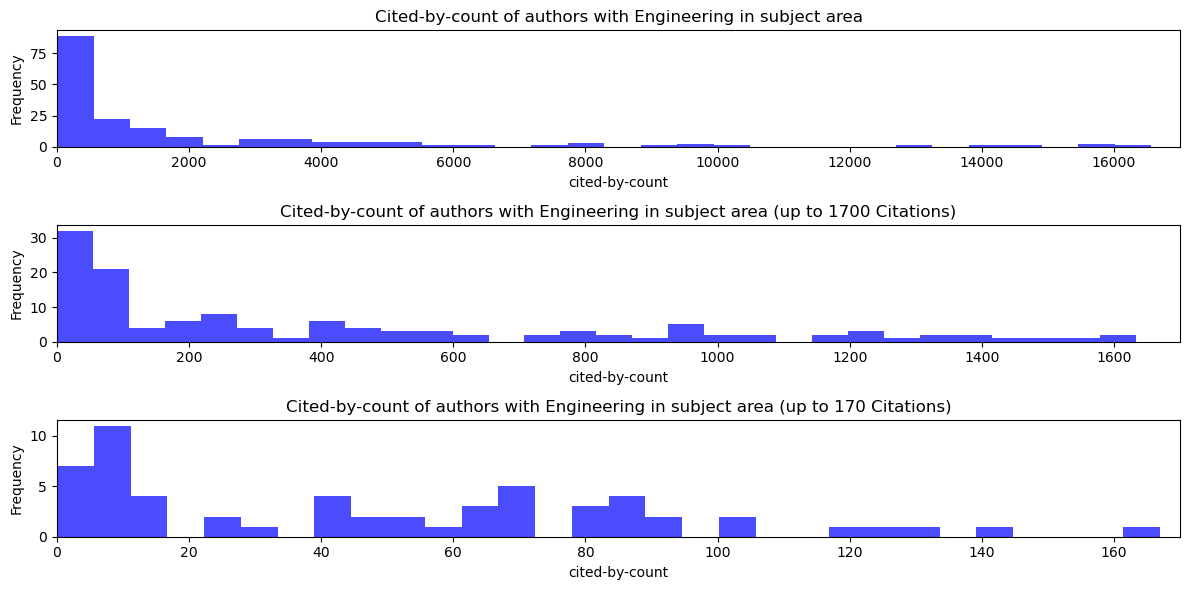

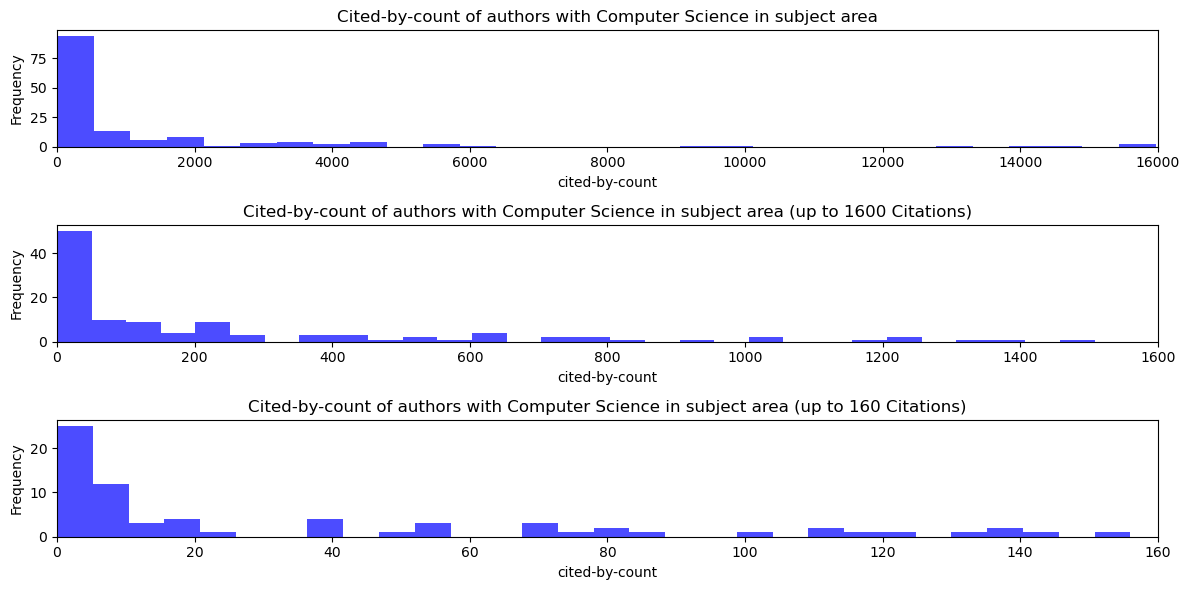

In [16]:
gen_histogram(engineering, 'Engineering', 'subject')
gen_histogram(cs, 'Computer Science', 'subject')

<Axes: title={'center': 'Boxplots of cited-by-count of authors'}, ylabel='Cited-by-Count'>

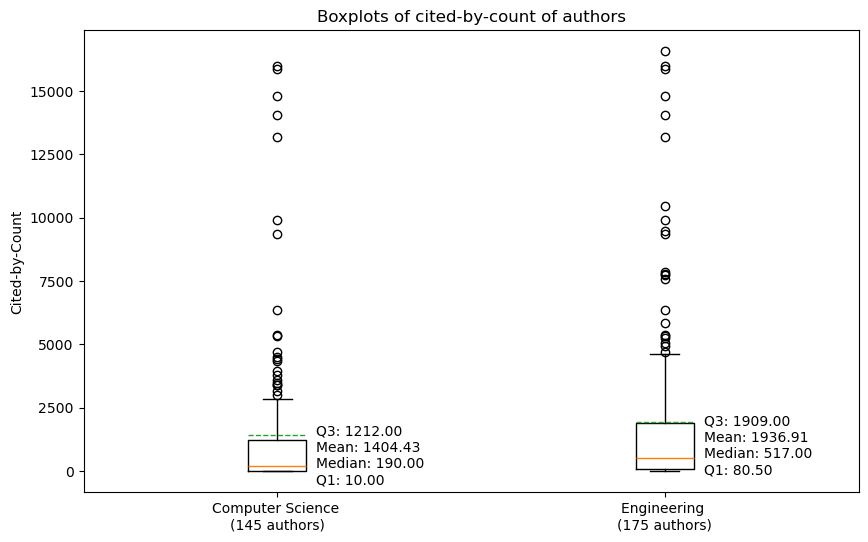

In [17]:
# Generate boxplots for cs and engineering cited-by-count
data = [
    [int(citation) for citation in cs.values()],
    [int(citation) for citation in engineering.values()]
]

gen_boxplot(data=data,
            tick_labels=[f'Computer Science \n({len(cs)} authors)', f'Engineering \n({len(engineering)} authors)'],
            title='Boxplots of cited-by-count of authors',
            ylabel='Cited-by-Count')

Anlaysis of citation count for papers with at least on author with subject "Computer Science" and papers with no author with "Computer Science" as subject.

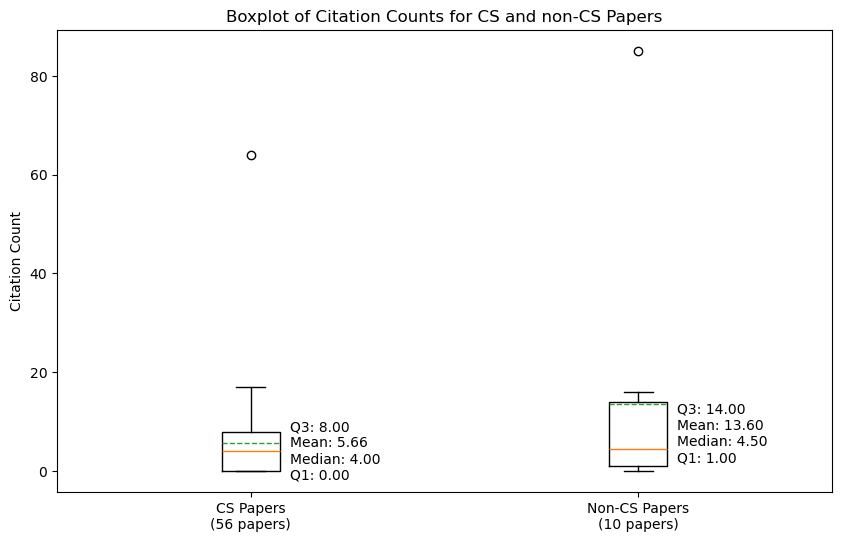

In [18]:
# Prepare data for boxplot
cs_paper_citations = [int(citation) for citation in cs_papers.values()]
non_cs_paper_citations = [int(citation) for citation in non_cs_papers.values()]

fig = gen_boxplot(data=[cs_paper_citations, non_cs_paper_citations],
            tick_labels=[f'CS Papers\n({len(cs_paper_citations)} papers)', f'Non-CS Papers\n({len(non_cs_paper_citations)} papers)'],
            title='Boxplot of Citation Counts for CS and non-CS Papers',
            ylabel='Citation Count')

### Reproducability Analysis

In [19]:
def find_paper_id(doi, doi_to_paper_id):
    result = doi_to_paper_id[doi_to_paper_id['DOI'].str.contains(doi, na=False)]
    if result.empty:
        print(f"Warning: DOI '{doi}' not found in the mapping.")
        return []
    else:
        try:
            return result["Paper ID"].values
        except KeyError:
            return result.index.values

def find_doi(paper_id, doi_to_paper_id, col="DOI"):
    result = doi_to_paper_id[doi_to_paper_id['Paper ID'] == paper_id][col]
    if not result.empty:
        return result.values[0]
    return None

def add_column(df, variable, column_name, doi_to_paper_id):
    for paper in variable:
        paper_id = find_paper_id(paper, doi_to_paper_id)
        if len(paper_id) > 0:
            df.loc[df.index == paper_id[0], column_name] = 1
    return df

In [20]:
cs_degree = pd.DataFrame()
non_cs_degree = pd.DataFrame()

# Filter data for CS and Non-CS papers
for paper in cs_papers.keys():
    if paper in numeric_data['DOI_short'].values or paper in numeric_data['DOI'].values:
        for col in ['D1', 'D2', 'D3', 'degree']:
            cs_degree.loc[paper, col] = dimensions.loc[find_paper_id(paper, numeric_data), col].values[0]
    else:
        print(f"Warning: DOI '{paper}' not found in the mapping.")

for paper in non_cs_papers.keys():
    if paper in numeric_data['DOI_short'].values:
        for col in ['D1', 'D2', 'D3', 'degree']:
            non_cs_degree.loc[paper, col] = dimensions.loc[find_paper_id(paper, numeric_data), col].values[0]
    else:
        print(f"Warning: DOI '{paper}' not found in the mapping.")


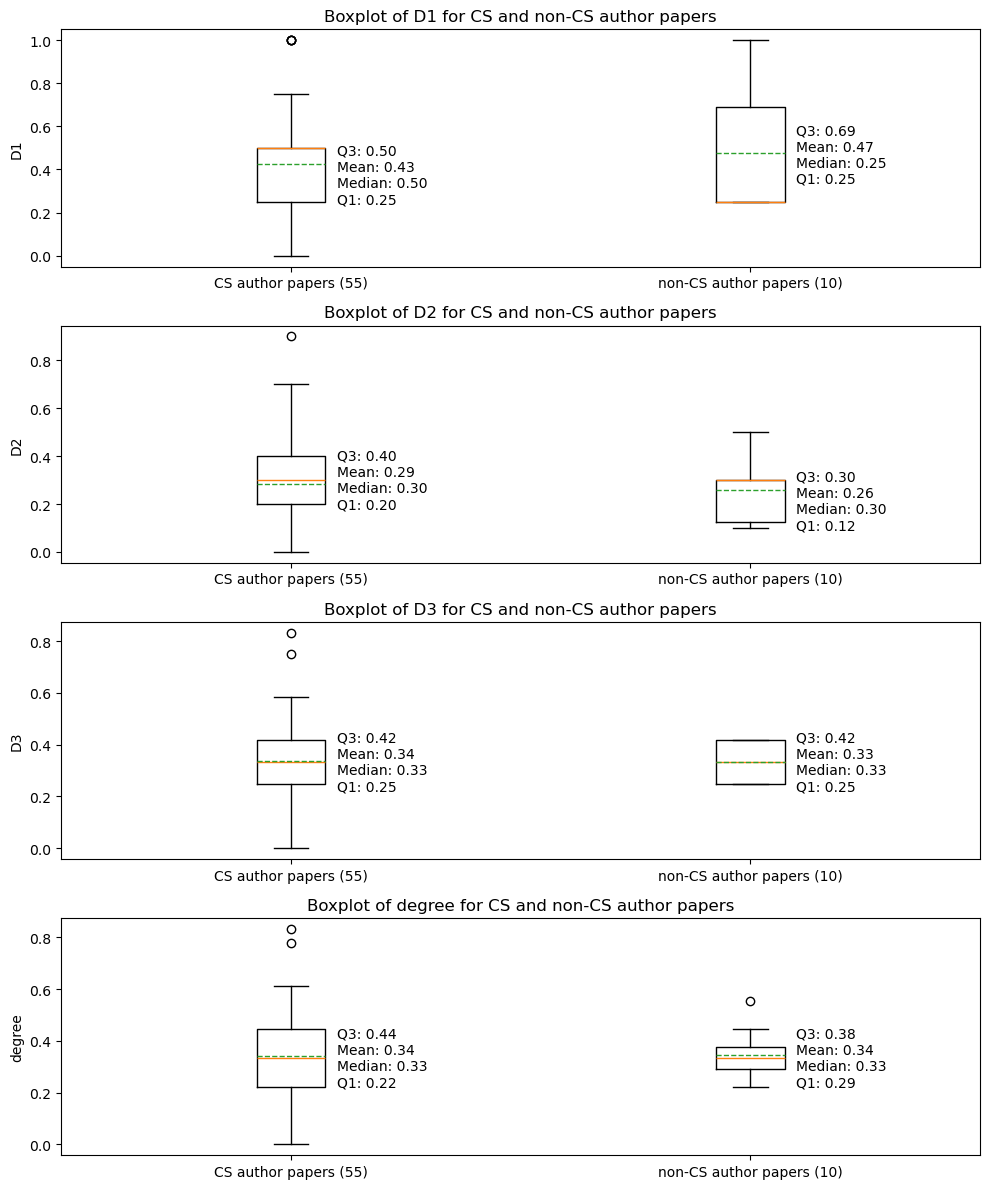

In [21]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12))
for ax, col in zip(axs, ['D1', 'D2', 'D3', 'degree']):
    gen_boxplot(data=[cs_degree[col], non_cs_degree[col]],
                tick_labels=[f'CS author papers ({len(cs_degree)})', f'non-CS author papers ({len(non_cs_degree)})'],
                title=f'Boxplot of {col} for CS and non-CS author papers',
                ylabel=col,
                show_stats=True,
                ax=ax)
fig.tight_layout()

## 3. Author Analysis: Affiliation

Analysis based on the author affilition type ("University", "Industry", "non-academic research") as described in `2_scopus_api_call.ipynb`. 

### Extract the affiliations

In [22]:
affil_types = {}
papers_affil_types = {}
authors_num = 0
authors_unique = 0
university = {}
industry = {}
research = {}

one_university_papers = []
one_industry_papers = []
one_research_papers = []

all_university_papers = []
all_industry_papers = []
all_research_papers = []

author_list = []
papers_all_same_affil_type = {'University': 0, 'Industry': 0, 'non-academic research': 0}

for paper in scopus_data:
    authors = paper.get('authors', [])
    paper_level_affil_types = {}
    for author in authors: 
        affil_type_list = author.get('affil-type', {})
        if type(affil_type_list) is not list:
            affil_type_list = [affil_type_list]
        
        for affil_type in affil_type_list:
            if affil_type not in paper_level_affil_types:
                paper_level_affil_types[affil_type] = 1

            if author['author-url'] not in author_list:
                # print(f'Author {author['author-url']} skipped')
                # continue
                authors_unique += 1

            authors_num += 1
            author_list.append(author['author-url'])
        
            
            if affil_type not in affil_types:
                affil_types[affil_type] = 0
            affil_types[affil_type] += 1
            if affil_type == 'University':
                university[author['author-url']] = int(author.get('cited-by-count'))
            if affil_type == 'Industry':
                industry[author['author-url']] = int(author.get('cited-by-count'))
            if affil_type == 'non-academic research':
                research[author['author-url']] = int(author.get('cited-by-count'))

    for affil_type in paper_level_affil_types:
        if affil_type not in papers_affil_types:
            papers_affil_types[affil_type] = 0
        papers_affil_types[affil_type] += 1

        if affil_type == 'University':
            if paper['doi'] not in one_university_papers:
                one_university_papers.append(paper['doi'])
        if affil_type == 'Industry':
            if paper['doi'] not in one_industry_papers:
                one_industry_papers.append(paper['doi'])
        if affil_type == 'non-academic research':
            if paper['doi'] not in one_research_papers:
                one_research_papers.append(paper['doi'])


    if len(set(paper_level_affil_types.keys())) == 1:
        affil = list(paper_level_affil_types.keys())[0]
        papers_all_same_affil_type[affil] += 1
        if affil == 'University':
            all_university_papers.append(paper['doi'])
        if affil == 'Industry':
            all_industry_papers.append(paper['doi'])
        if affil == 'non-academic research':
            all_research_papers.append(paper['doi'])
   
papers_affil_types = dict(sorted(papers_affil_types.items(), key=lambda item: item[1], reverse=True))
affil_types = dict(sorted(affil_types.items(), key=lambda item: item[1], reverse=True))

university = dict(sorted(university.items(), key=lambda item: item[1], reverse=True))
industry = dict(sorted(industry.items(), key=lambda item: item[1], reverse=True))
research = dict(sorted(research.items(), key=lambda item: item[1], reverse=True))
print('Num of authors:', authors_num)

affil_types

Num of authors: 278


{'University': 212, 'Industry': 36, 'non-academic research': 30}

### Affiliation Analysis

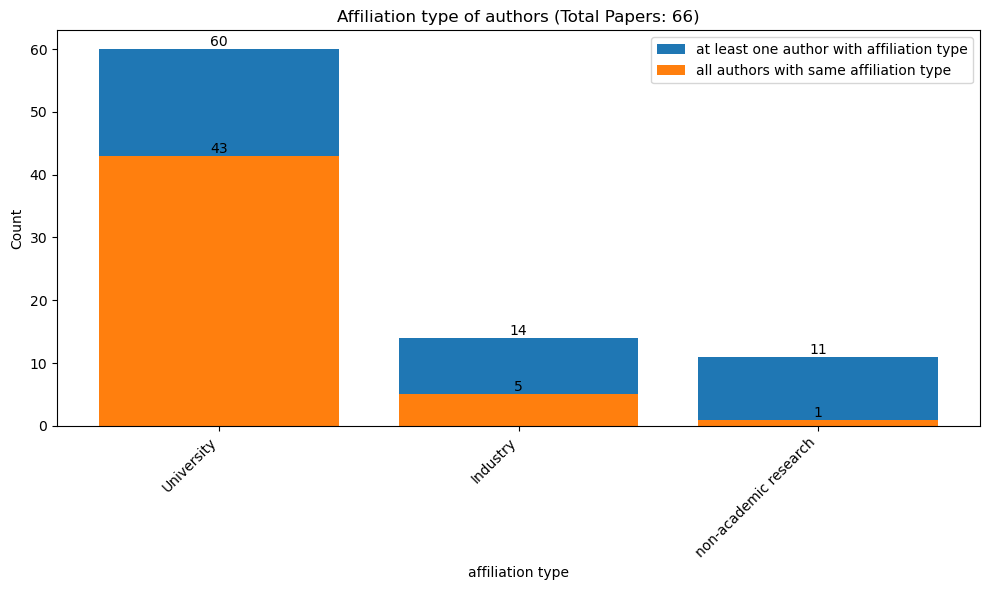

In [23]:
plt.figure(figsize=(10, 6))
bars = plt.bar(papers_affil_types.keys(), papers_affil_types.values(), label='at least one author with affiliation type')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')
bars_all = plt.bar(papers_all_same_affil_type.keys(), papers_all_same_affil_type.values(), label='all authors with same affiliation type')
for bar in bars_all:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.title(f'Affiliation type of authors (Total Papers: {len(scopus_data)})')
plt.xlabel('affiliation type')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

### Citation Analysis

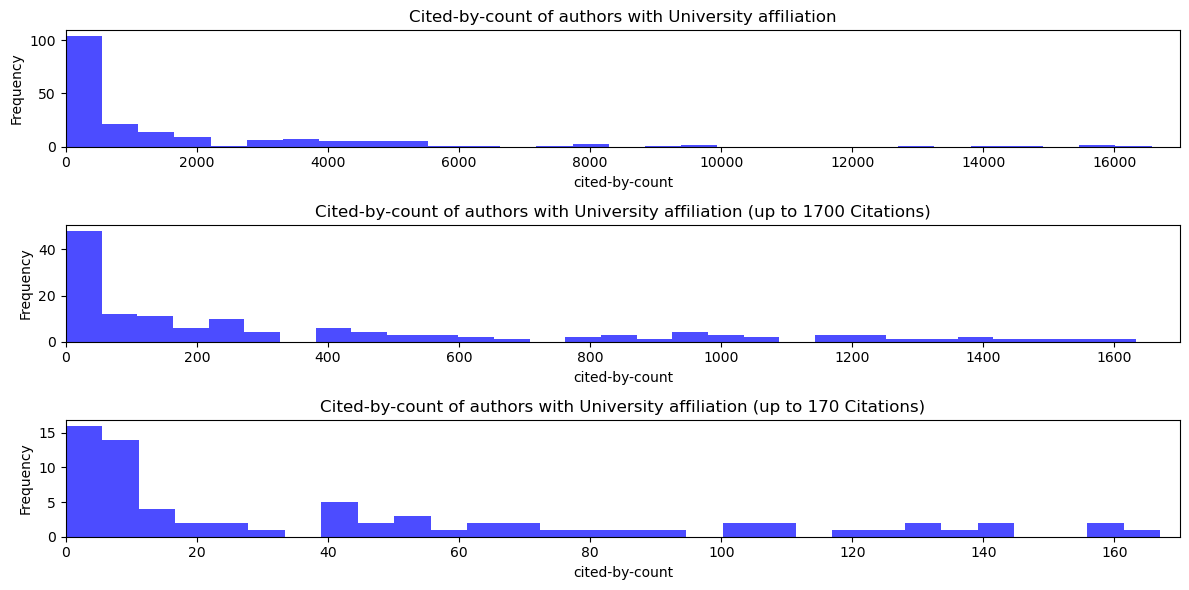

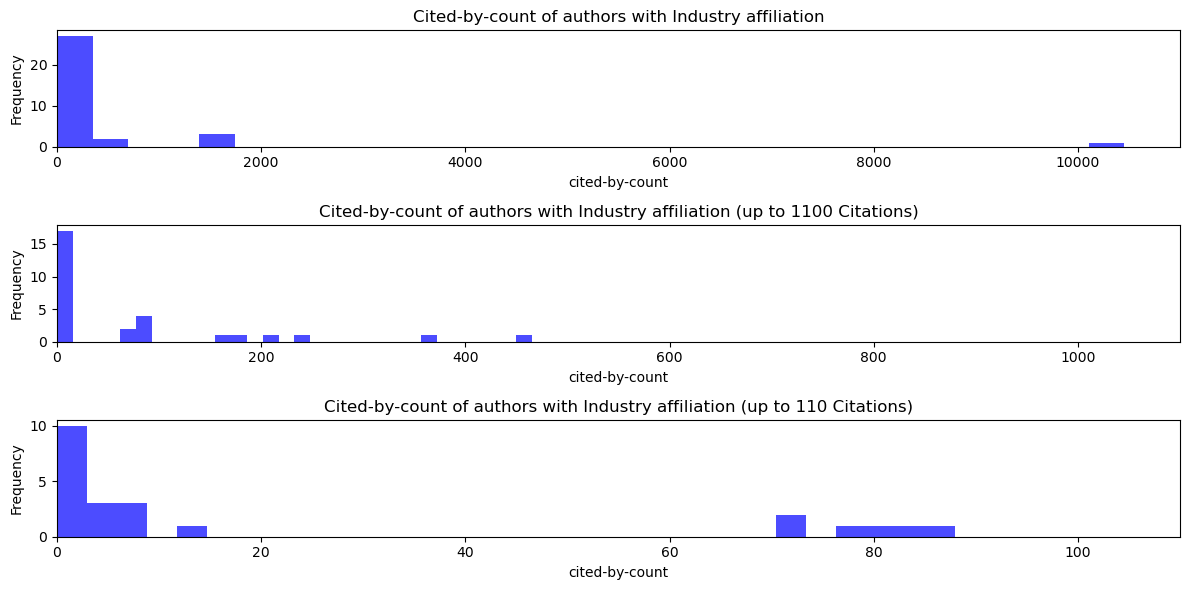

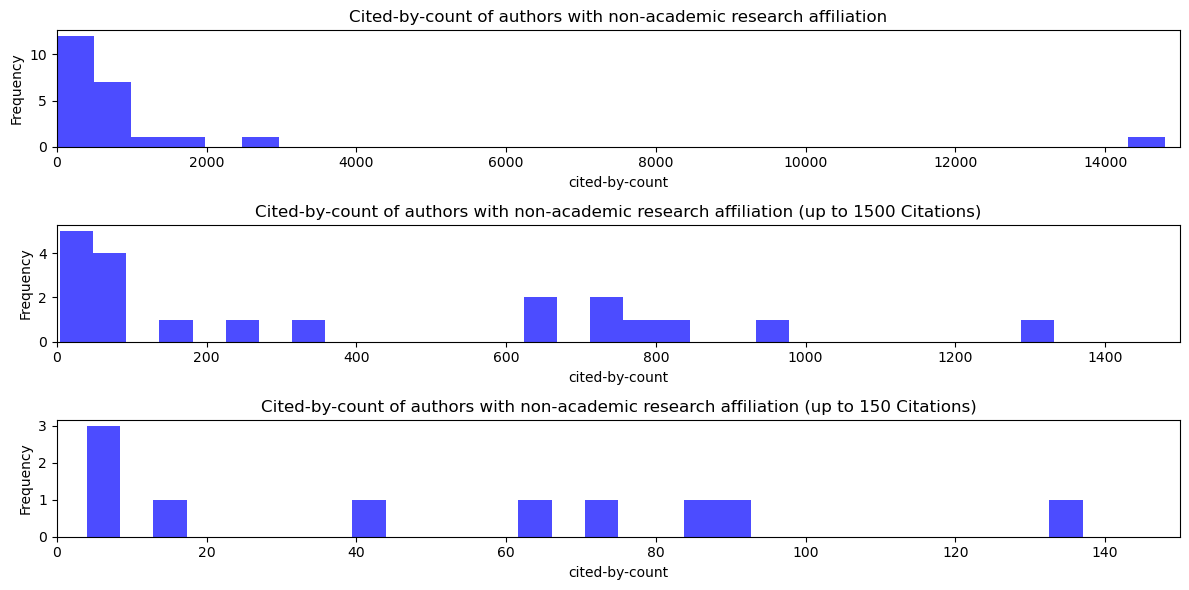

In [24]:
gen_histogram(university, 'University', stat_type='affil')
gen_histogram(industry, 'Industry', stat_type='affil')
gen_histogram(research, 'non-academic research', stat_type='affil')

<Axes: title={'center': 'Boxplots of cited-by-count of authors'}, ylabel='Cited-by-Count'>

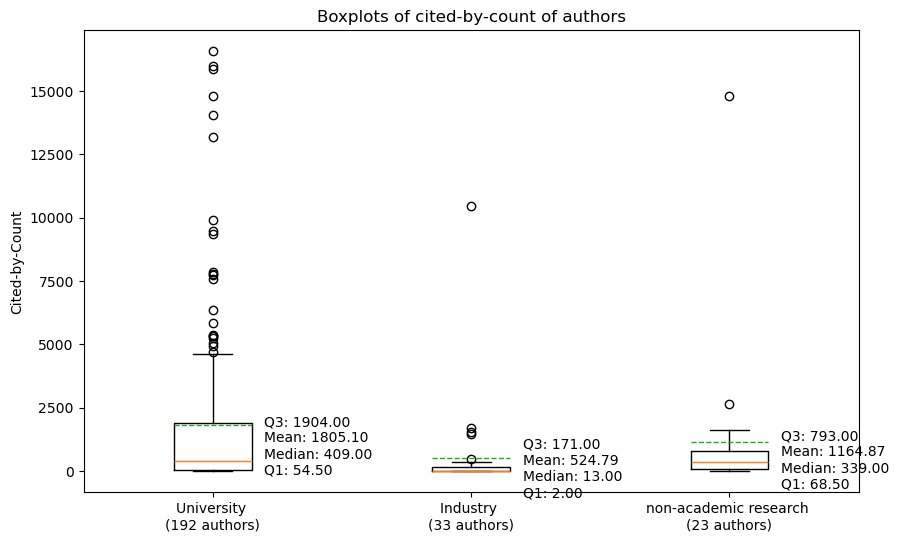

In [25]:
# Generate boxplots for cs and University cited-by-count

data = [
    [int(citation) for citation in university.values()],
    [int(citation) for citation in industry.values()],
    [int(citation) for citation in research.values()]
]

gen_boxplot(data=data,
            tick_labels=[f'University \n({len(university.values())} authors)', 
                         f'Industry \n({len(industry.values())} authors)', 
                         f'non-academic research \n({len(research.values())} authors)'],
            title='Boxplots of cited-by-count of authors',
            ylabel='Cited-by-Count')


### Reproducability Analysis

Investigate the correlation between the affiliation type and the reproducability score.

In [26]:
variables = [one_university_papers, one_industry_papers, one_research_papers, all_university_papers, all_industry_papers, all_research_papers]
variables_names = ['one_university', 'one_industry', 'one_research', 'all_university', 'all_industry', 'all_research']

for variable, variable_name in zip(variables, variables_names):
    dimensions = add_column(dimensions, variable, variable_name, numeric_data)


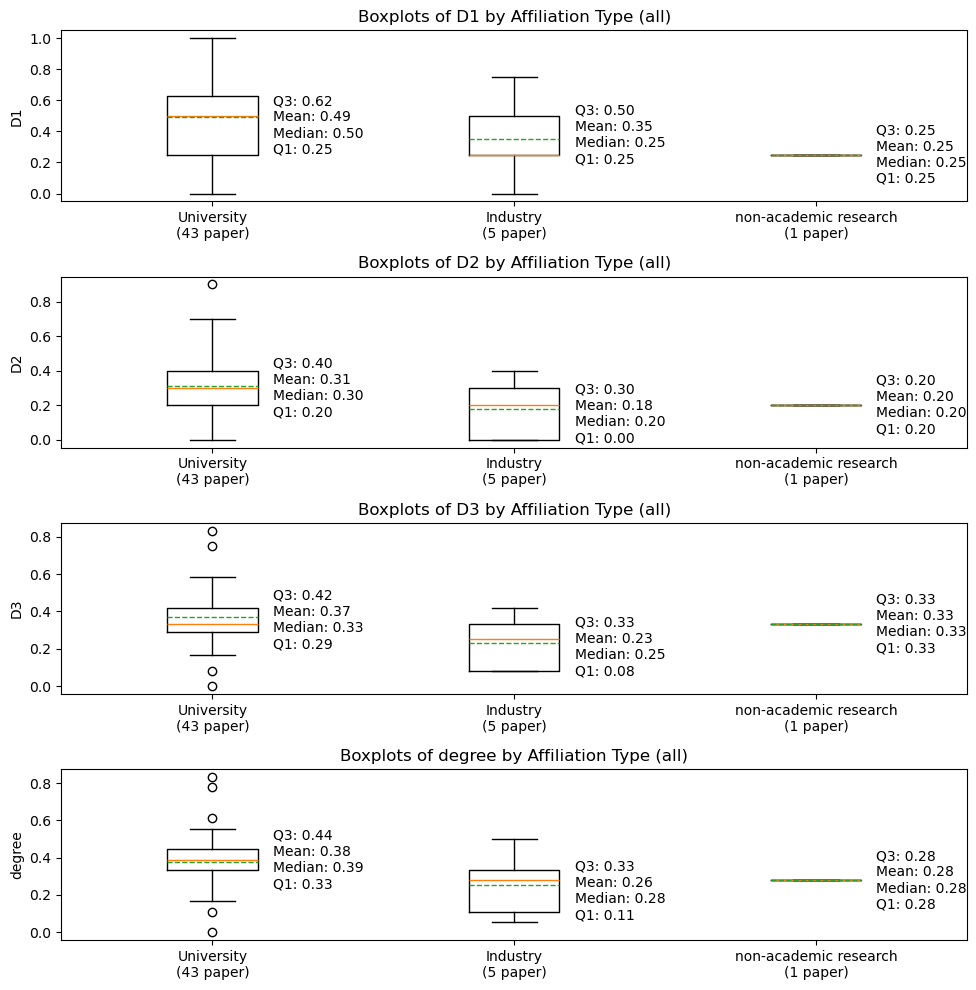

In [27]:
# Filter data for each affiliation type
all_university = dimensions[dimensions['all_university'] == 1]
all_industry = dimensions[dimensions['all_industry'] == 1]
all_research = dimensions[dimensions['all_research'] == 1]

# Create boxplot
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
data = [all_university, all_industry, all_research]
for ax, variable in zip(axs, ['D1', 'D2', 'D3', 'degree']):
    data = [all_university[variable], all_industry[variable], all_research[variable]]
    gen_boxplot(
        data=data,
        tick_labels=[f'University\n({len(all_university)} paper)', f'Industry\n({len(all_industry)} paper)', f'non-academic research\n({len(all_research)} paper)'],
        title=f'Boxplots of {variable} by Affiliation Type (all)',
        ylabel=f'{variable}',
        show_stats=True,
        ax=ax
    )
fig.tight_layout()


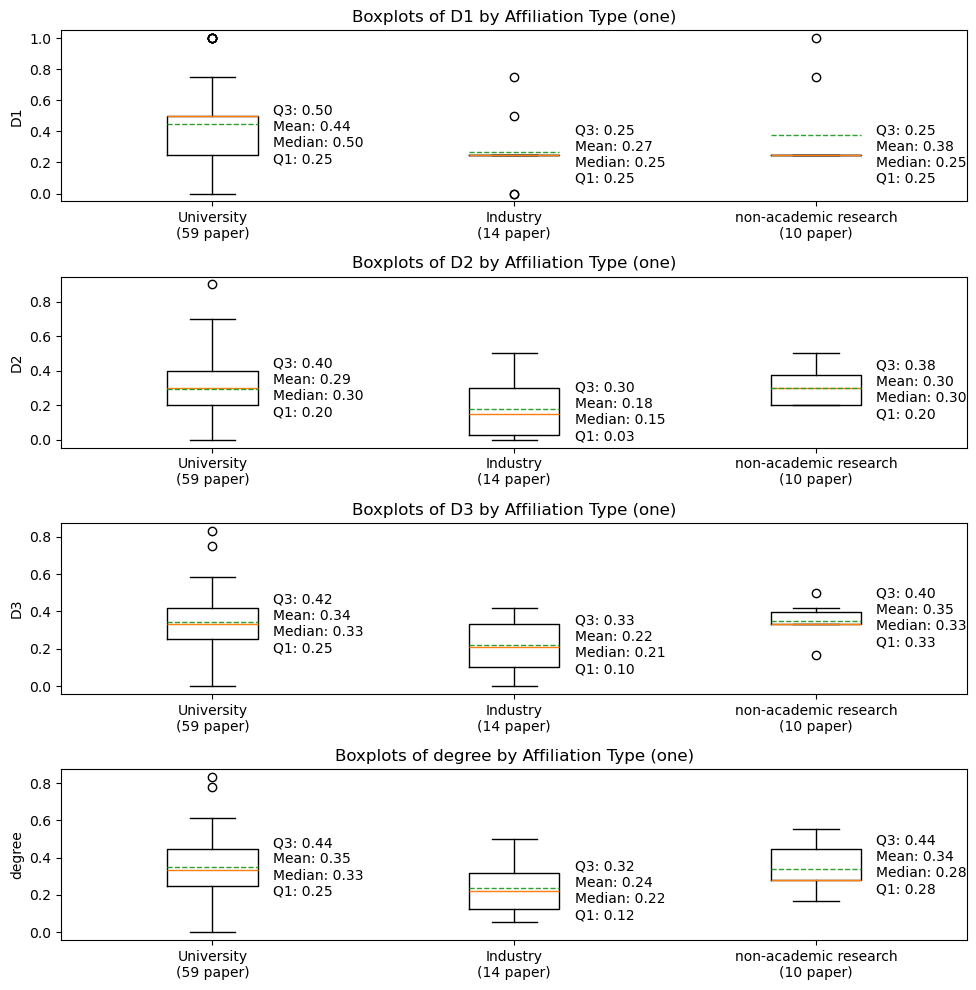

In [28]:
# Filter data for each affiliation type
one_university = dimensions[dimensions['one_university'] == 1]
one_industry = dimensions[dimensions['one_industry'] == 1]
one_research = dimensions[dimensions['one_research'] == 1]

# Create boxplot
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for ax, variable in zip(axs, ['D1', 'D2', 'D3', 'degree']):
    data = [one_university[variable], one_industry[variable], one_research[variable]]
    gen_boxplot(
        data=data,
        tick_labels=[f'University\n({len(one_university)} paper)', f'Industry\n({len(one_industry)} paper)', f'non-academic research\n({len(one_research)} paper)'],
        title=f'Boxplots of {variable} by Affiliation Type (one)',
        ylabel=f'{variable}',
        show_stats=True,
        ax=ax
    )
fig.tight_layout()

## 4. Citations vs. Reproducability

In [29]:
def add_lin_fit(x, y, ax):
    X = sm.add_constant(x)

    model = sm.OLS(y, X)
    results = model.fit()

    params = results.params
    errors = results.bse 
    
    x_ = np.linspace(0, 1, 100)
    y_fit = params.iloc[0] + params.iloc[1] * x_
    y_fit_upper = params.iloc[0] + 1.98 * errors.iloc[0] + (params.iloc[1] + 1.98 * errors.iloc[1]) * x_
    y_fit_lower = params.iloc[0] - 1.98 * errors.iloc[0] + (params.iloc[1] - 1.98 * errors.iloc[1]) * x_
    ax.plot(x_, y_fit, color='red', linewidth=1, linestyle='--', label=f'y = {params.iloc[0]:.1f}$\\pm${errors.iloc[0]:.1f}+({params.iloc[1]:.1f}$\\pm${errors.iloc[1]:.1f})x')
    ax.fill_between(x_, y_fit_lower, y_fit_upper, color='red', alpha=0.1, label='95% CI')
    ax.legend()

    print(f"Slope ({x.name}): {params.iloc[1]:.4f} ± {errors.iloc[1]:.4f}; p-value: {results.pvalues.iloc[1]:.6f}")
    print(f"Intercept: {params.iloc[0]:.4f} ± {errors.iloc[0]:.4f}; p-value: {results.pvalues.iloc[0]:.6f}")
    print(f"R-squared: {results.rsquared:.4f}")
    print("-" * 40)
    return ax

In [30]:
for paper in scopus_data:
    paper_id = find_paper_id(paper['doi'], numeric_data)
    if len(paper_id) > 0:
        dimensions.loc[paper_id[0], 'citation-count'] = int(paper.get('citation-count'))
    else:
        print(f"Warning: DOI '{paper['doi']}' not found in the mapping.")
dimensions['citation-count'] = dimensions['citation-count'].astype(int)

Slope (D1): 7.0806 ± 6.2103; p-value: 0.258547
Intercept: 3.8304 ± 3.1584; p-value: 0.229757
R-squared: 0.0202
----------------------------------------
Slope (D2): -0.5009 ± 9.4051; p-value: 0.957693
Intercept: 7.0487 ± 3.1237; p-value: 0.027515
R-squared: 0.0000
----------------------------------------
Slope (D3): 1.8614 ± 10.9586; p-value: 0.865670
Intercept: 6.2825 ± 4.0366; p-value: 0.124631
R-squared: 0.0005
----------------------------------------
Slope (degree): 1.4732 ± 10.4994; p-value: 0.888864
Intercept: 6.4040 ± 3.9535; p-value: 0.110261
R-squared: 0.0003
----------------------------------------


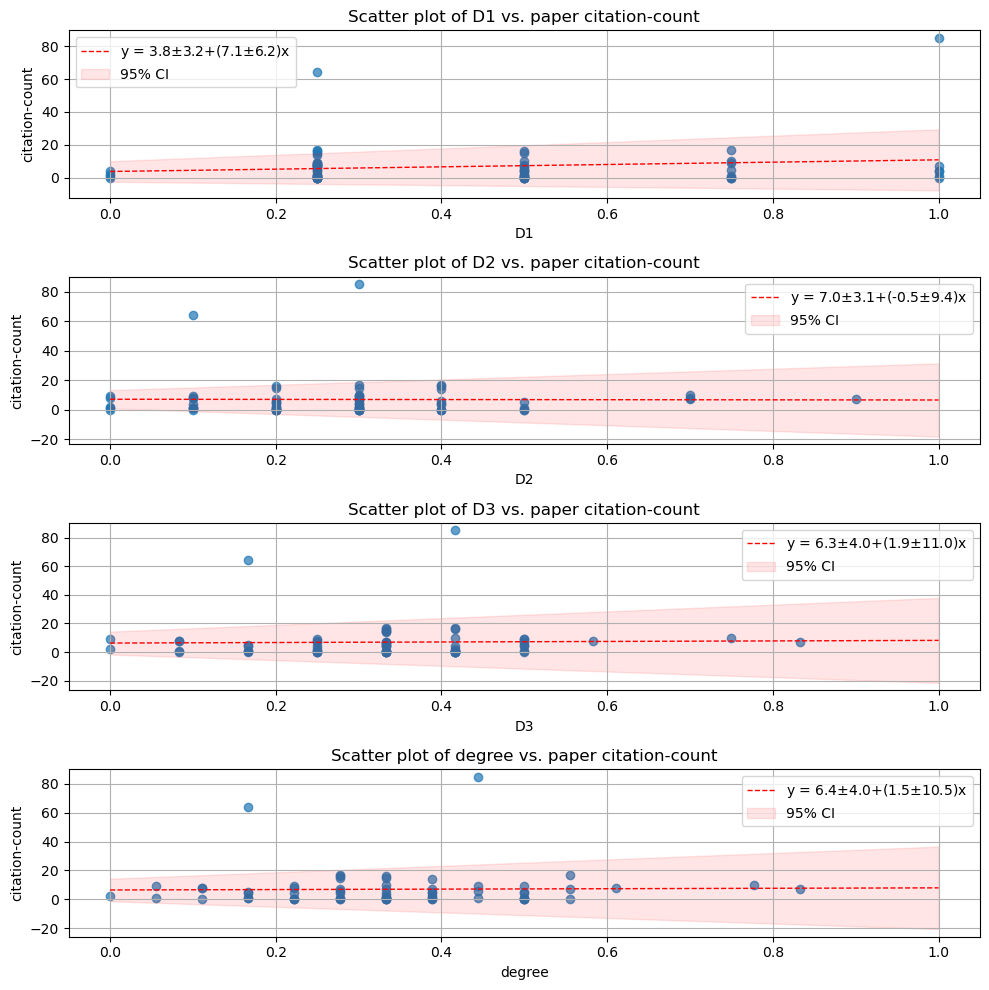

In [31]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for ax, variable in zip(axs, ['D1', 'D2', 'D3', 'degree']):
    ax.scatter(dimensions[variable], dimensions['citation-count'], alpha=0.7)
    ax.set(
        xlabel=variable, 
        ylabel='citation-count', 
        title=f'Scatter plot of {variable} vs. paper citation-count')
    ax = add_lin_fit(dimensions[variable], dimensions['citation-count'], ax)
    ax.grid(True)
fig.tight_layout()